In [ ]:
#| hide
from Pytorch_Nerf.core import *

# Nerf_reimplementation
> a simple pytorch reimplementation of nerf

Novel View Synthesis (NVS) is the process of generating images from new camera viewpoints based on a set of input 2D images. Historically, the field has been dominated by geometry-based methods, such as Structure from Motion (SfM) and Multi-View Stereo (MVS), where the reconstruction process is explicit:

Feature matching – detect keypoints in images and match them across views

Camera pose estimation – determine the relative positions and orientations of the cameras

Triangulation – compute 3D point positions to produce a sparse or dense point cloud

In recent years, radiance field methods have emerged as the state-of-the-art. A radiance field represents how light is distributed and interacts with a scene, allowing new views to be synthesized without explicitly reconstructing geometry.

One influential implicit method is [NeRF](https://arxiv.org/pdf/2003.08934). The idea is conceptually simple: a neural network (MLP) takes a 5D coordinate – a 3D position
𝑥
x and a 2D viewing direction
𝑑
d – and outputs a color and density:

𝑓
(
𝑥
,
𝑑
)
→
(
𝑐
,
𝜎
)
f(x,d)→(c,σ)

## 1. From Pixels to Rays
We will begin with loading the [dataset](https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz).


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import optim
import plotly.graph_objects as go


In [10]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']


(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


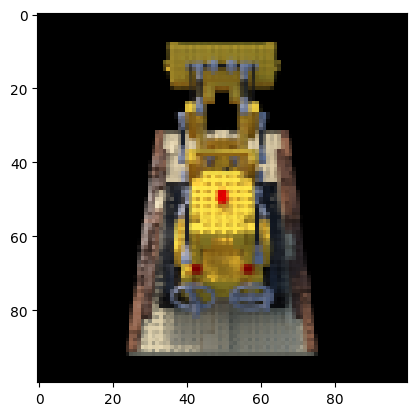

In [11]:
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[102], poses[102]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

We want to compute, for every image pixel $(i, j)$:

- The ray origin $o_{ij} \in \mathbb{R}^3$  
- The ray direction $d_{ij} \in \mathbb{R}^3$

such that any 3D point along the ray can be expressed as:

$$
r_{ij}(t) = o_{ij} + t \, d_{ij}, \quad t \ge 0
$$


Step 1 — Pinhole Camera Projection Model

In the camera coordinate system, a 3D point $(X_c, Y_c, Z_c)$ projects onto the image plane as:

$$
x = f \frac{X_c}{Z_c}, \quad y = f \frac{Y_c}{Z_c}
$$

where $f$ is the focal length (in pixels).

Inversely, for a given pixel $(i, j)$, the camera-space direction of the corresponding ray is:

$$
d_{ij}^{(c)} =
\left[
\frac{(i - W/2)}{f},\;
-\frac{(j - H/2)}{f},\;
-1
\right]
$$

The subtraction by $W/2$ and $H/2$ centers the image at the origin.  
The negative signs ensure that the camera looks down the $-z$ axis, following NeRF’s convention.


Step 2 — Transforming from Camera Space to World Space

Each ray direction in camera coordinates must be rotated into the world coordinate system using the rotation matrix:

$$
R = \text{c2w}[:3, :3]
$$

and the camera’s origin in world space is given by:

$$
t = \text{c2w}[:3, 3]
$$

Hence:

$$
d_{ij} = R \, d_{ij}^{(c)}
$$

$$
o_{ij} = t
$$


In [12]:
def get_rays(H, W, focal, c2w):
    """
    Get ray origins and directions for all pixels in an image.

    Args:
        H (int): Image height
        W (int): Image width
        focal (float): Focal length (in pixels)
        c2w (torch.Tensor): [4, 4] camera-to-world transformation matrix

    Returns:
        rays_o: [H, W, 3] origin of each ray (camera center in world space)
        rays_d: [H, W, 3] direction of each ray (in world space)
    """
    device = c2w.device

    # Create pixel coordinate grid
    i, j = torch.meshgrid(
        torch.arange(W, dtype=torch.float32, device=device),
        torch.arange(H, dtype=torch.float32, device=device),
        indexing='xy'
    )

    # Convert pixel coordinates to camera space directions
    dirs = torch.stack([
        (i - W * 0.5) / focal,
        -(j - H * 0.5) / focal,
        -torch.ones_like(i)
    ], dim=-1)  # [H, W, 3]

    # Rotate directions from camera space to world space
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], dim=-1)  # [H, W, 3]

    # Every ray originates from the same camera center
    rays_o = c2w[:3, -1].expand(rays_d.shape)  # [H, W, 3]
    return rays_o, rays_d

## 2. Volume Rendering

### 2.1. Ray Parameterization

Volume rendering is a technique used to compute the color of any camera ray:

$$
\mathbf{r}(t) = \mathbf{o} + t \mathbf{d}, \quad t \in [t_n, t_f]
$$

where $\mathbf{o}$ represents the camera position, $\mathbf{d}$ is the viewing direction, and $t_n$ and $t_f$ denote the near and far bounds of the ray.  
As the ray travels through the scene, it accumulates light contributions from all the points it intersects.

### 2.2. Light Absorption and Emission

For a differential segment of length $dt$ at depth $t$, the probability that the ray interacts with particles in that segment is proportional to the local volume density:

$$
P(\text{interaction at } t) = \sigma(t) \, dt
$$

To derive the **transmittance** $T(t)$:

$$
T(t + dt) = T(t) \cdot (1 - \sigma(t) dt)
$$

$$
T(t + dt) - T(t) = -T(t)\sigma(t) dt
$$

$$
\frac{dT(t)}{dt} = -\sigma(t) T(t)
$$

$$
T(t) = \exp\Big(-\int_{t_0}^{t} \sigma(s) \, ds\Big)
$$

### 2.3. Continuous Volume Rendering Equation

By weighting the emitted color $c(t)$ by this probability (learned by the nn), the expected color observed along the ray can be expressed as:

$$
C(\mathbf{r}) = \int_{t_n}^{t_f} T(t) \, \sigma(t) \, c(t) \, dt
$$

This integral computes the accumulated radiance from all points along the ray, attenuated by the transmittance of the medium.

### 2.4. Discrete Approximation

In practice, this continuous integral cannot be solved analytically and is approximated numerically using a quadrature method. NeRF modifies this approach by using stratified sampling: the interval $[t_n, t_f]$ is divided into $N$ evenly spaced bins, and one sample is drawn uniformly at random from each bin. This stochastic sampling helps to better represent a continuous scene.

$$
t_i \sim \mathcal{U}\Bigg[t_n + \frac{i-1}{N}(t_f - t_n), \; t_n + \frac{i}{N}(t_f - t_n)\Bigg]
$$

Assuming the density is constant over each small interval $\delta_i = t_{i+1} - t_i$, the discrete form becomes:

$$
C(\mathbf{r}) \approx \sum_{i=1}^{N} T_i \, \alpha_i \, c_i
$$

$$
\alpha_i = 1 - \exp(-\sigma_i \, \delta_i)
$$

$$
T_i = \prod_{j=1}^{i-1} (1 - \alpha_j)
$$

$$
C(\mathbf{r}) = \sum_{i=1}^{N} w_i \, c_i, \quad \text{with } w_i = T_i \, (1 - e^{-\sigma_i \delta_i})
$$

Here, $\alpha_i$ represents the **opacity** of the $i$-th sample, while $T_i$ is the **accumulated transmittance**.  
The weighted sum computes the final color along the ray and allows gradients to propagate smoothly through the sampling process for end-to-end optimization.


In [14]:
from dataclasses import dataclass

class RayBundle:
    def __init__(self, origins, directions, nears, fars):
        self.origins = origins
        self.directions = directions
        self.nears = nears
        self.fars = fars

    def __len__(self):
        return self.origins.shape[0]

    def stratified_sample(self, num_samples=64, perturb=True):
        num_rays = len(self)
        device = self.origins.device
        bins = torch.linspace(0.0, 1.0, num_samples + 1, device=device)[None, :]
        bins = self.nears + (self.fars - self.nears) * bins
        t_start, t_end = bins[:, :-1], bins[:, 1:]
        if perturb:
            u = torch.rand(num_rays, num_samples, device=device)
            t_samples = t_start + (t_end - t_start) * u
        else:
            t_samples = 0.5 * (t_start + t_end)
        return RaySamples(self, t_samples)

class RaySamples:
    def __init__(self, ray_bundle, t_samples):
        self.ray_bundle = ray_bundle
        self.t_samples = t_samples

    def compute_sample_coordinates(self):
        return self.ray_bundle.origins[:, None, :] + self.t_samples[:, :, None] * self.ray_bundle.directions[:, None, :]

    def compute_deltas(self):
        deltas = self.t_samples[:, 1:] - self.t_samples[:, :-1]
        last_delta = torch.full_like(deltas[:, :1], 1.0)
        return torch.cat([deltas, last_delta], dim=-1)

def volume_render(sigmas, rgbs, deltas):
    sigmas = sigmas.squeeze(-1)
    alphas = 1.0 - torch.exp(-sigmas * deltas)
    T = torch.cumprod(torch.cat([torch.ones_like(alphas[:, :1]), 1.0 - alphas[:, :-1] + 1e-10], dim=-1), dim=-1)
    weights = alphas * T
    final_rgb = (weights[..., None] * rgbs).sum(dim=-2)
    acc_opacity = weights.sum(dim=-1, keepdim=True)
    return final_rgb, weights, acc_opacity



## 3.Model Architecture
The authors wanted the model to be multi-view consistent, so they predict the color density σ based only on the 3D position x, while predicting the RGB color c as a function of both position x and viewing direction d.  

All hidden layers are followed by ReLU activations, and a Sigmoid activation is applied at the output to obtain the RGB values.


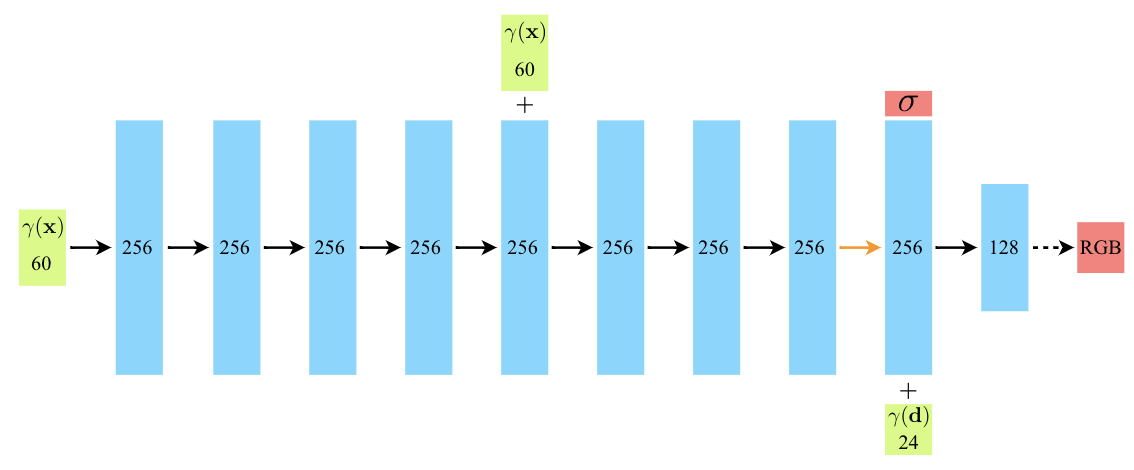

In [15]:
class nerf_mlp(nn.Module):
    def __init__(self, input_dim=63, dir_dim=27, skips=[4]):
        super().__init__()
        self.skips = skips
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for i in range(8):
            if i in skips:
                in_dim += input_dim
            self.layers.append(nn.Linear(in_dim, 256))
            in_dim = 256
        self.sigma_layer = nn.Linear(256, 1)
        self.feature_layer = nn.Linear(256, 256)
        self.rgb_layers = nn.Sequential(
            nn.Linear(256 + dir_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x, d):
        h = x
        for i, layer in enumerate(self.layers):
            if i in self.skips:
                h = torch.cat([h, x], dim=-1)
            h = F.relu(layer(h))
        sigma = self.sigma_layer(h)
        features = self.feature_layer(h)
        rgb = torch.sigmoid(self.rgb_layers(torch.cat([features, d], dim=-1)))
        return sigma, rgb

## 4. Positional Encoding

Feeding the raw input coordinates (x, y, z, θ, φ) directly into a network results in poor-quality rendering. This happens because deep networks are biased towards learning lower frequencies, as explained in [Rahaman et al., 2019](https://proceedings.mlr.press/v97/rahaman19a.html).  

To address this, the NeRF authors map the input to a higher-dimensional space using positional encoding (Fourier features) before feeding it into the MLP. This significantly improves the rendering quality.  

To demonstrate this, the authors suggest training an MLP for color prediction using different input mappings, showing the benefits of Fourier features. Below is an implementation based on their [paper](https://bmild.github.io/fourfeat/index.html) adapted from the original JAX code.
### 4.1.Preprocessing


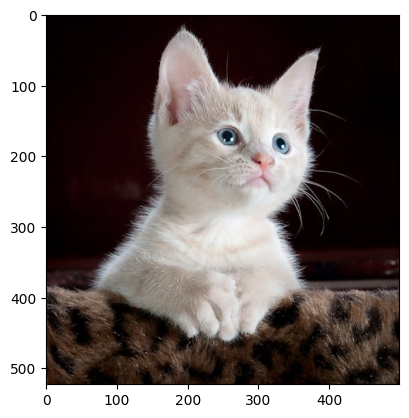

In [13]:
img=plt.imread("kitty.jpeg")
plt.imshow(img)

coords shape: (261500, 2)
colors shape: (261500, 3)
train_coords shape: (65500, 2)
test_coords shape: (261500, 2)


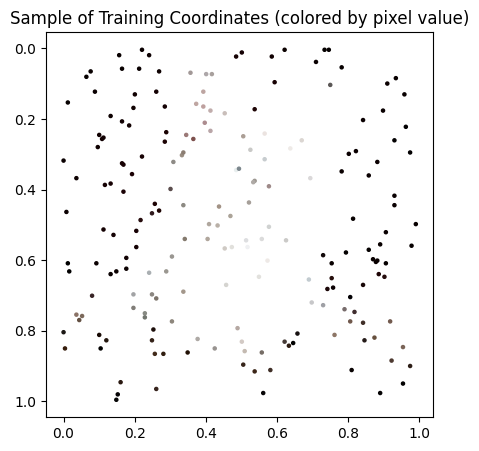

In [4]:
h, w, _ = img.shape

colors = img.reshape(-1, 3).astype(np.float32)
if colors.max() > 1.0:
    colors /= 255.0

y_coords = np.linspace(0, 1, h)
x_coords = np.linspace(0, 1, w)
y_grid, x_grid = np.meshgrid(y_coords, x_coords, indexing='ij')
coords_norm = np.stack([x_grid, y_grid], axis=-1)

print("coords shape:", coords_norm.reshape(-1, 2).shape)
print("colors shape:", colors.shape)

# Training data: downsample by 2
train_coords = coords_norm[::2, ::2].reshape(-1, 2)
train_colors = colors.reshape(h, w, 3)[::2, ::2].reshape(-1, 3)

# Test data: full resolution
test_coords = coords_norm.reshape(-1, 2)
test_colors = colors
train_coords = train_coords.astype(np.float32)
test_coords  = test_coords.astype(np.float32)

print("train_coords shape:", train_coords.shape)
print("test_coords shape:", test_coords.shape)

#
idx = np.random.choice(len(train_coords), 200, replace=False)
plt.figure(figsize=(5,5))
plt.scatter(train_coords[idx,0], train_coords[idx,1], c=train_colors[idx], s=5)
plt.gca().invert_yaxis()
plt.title("Sample of Training Coordinates (colored by pixel value)")
plt.show()

### 4.2. Input Mapping

- No mapping:  
x = [x, y] ∈ R²

- Basic Fourier mapping:  
phi_basic(x) = [sin(x1), sin(x2), cos(x1), cos(x2)] ∈ R⁴  
Each 2D coordinate is expanded to 4 features.

- Gaussian Fourier Features:  
phi(x) = [sin(2π B x), cos(2π B x)] ∈ R^(2 * mapping_size)  
Here,   B ∈ R^(mapping_size × 2) is a Gaussian random matrix.  
Each 2D coordinate is projected onto 256 random directions and expanded via sine and cosine functions, resulting in a 512-dimensional vector.


In [5]:
def input_mapping(x, B):
    x = x.astype(np.float32)
    if B is None:
        return x
    else:
        x_proj = (2.*np.pi*x) @ B.T
        return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)
mapping_size = 256
B_dict = {}

# Standard network - no mapping
B_dict['none'] = None

# Basic mapping
B_dict['basic'] = np.eye(2)

# Gaussian Fourier features at different scales
np.random.seed(0)
B_gauss = np.random.normal(size=(mapping_size, 2))
for scale in [1, 10, 100]:
    B_dict[f'gauss_{scale}'] = B_gauss * scale


In [6]:
class ImageCoordDataset(Dataset):
    def __init__(self, coords, colors, B=None):
        coords_mapped = input_mapping(coords, B)
        self.coords = torch.tensor(coords_mapped, dtype=torch.float32)
        self.colors = torch.tensor(colors, dtype=torch.float32)

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        return self.coords[idx], self.colors[idx]

def get_loaders(B, batch_size_train=128, batch_size_test=512):
    train_dataset = ImageCoordDataset(train_coords, train_colors, B)
    test_dataset  = ImageCoordDataset(test_coords, test_colors, B)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
    return train_loader, test_loader

Training Loop

In [7]:
def create_mlp(input_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 3),
        nn.Sigmoid()
    )
def train_network(B_name, B, epochs=15, lr=1e-3):
    print(f"\n=== Training with mapping: {B_name} ===")

    train_loader, test_loader = get_loaders(B)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Determine input_dim automatically from one batch
    sample_coords = next(iter(train_loader))[0].numpy()
    input_dim = sample_coords.shape[1]

    model = create_mlp(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    psnr_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for coords_batch, colors_batch in train_loader:
            coords_batch = coords_batch.to(device)
            colors_batch = colors_batch.to(device)

            optimizer.zero_grad()
            preds = model(coords_batch)
            loss = criterion(preds, colors_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * coords_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # PSNR evaluation
        model.eval()
        psnr_total = 0.0
        with torch.no_grad():
            for coords_batch, colors_batch in test_loader:
                coords_batch = coords_batch.to(device)
                colors_batch = colors_batch.to(device)
                preds = model(coords_batch)
                mse = torch.mean((preds - colors_batch) ** 2)
                psnr_batch = 10 * torch.log10(1.0 / mse)
                psnr_total += psnr_batch * coords_batch.size(0)
        psnr_avg = psnr_total / len(test_loader.dataset)
        psnr_list.append(psnr_avg.item())

        print(f"Epoch [{epoch+1}/{epochs}]  Train Loss: {epoch_loss:.6f}  PSNR: {psnr_avg:.2f} dB")

    return model, train_losses, psnr_list


def plot_results(model, B, B_name):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    with torch.no_grad():
        coords_flat = coords_norm.reshape(-1, 2)
        coords_mapped = torch.tensor(input_mapping(coords_flat, B), dtype=torch.float32).to(device)
        preds = model(coords_mapped).cpu().numpy()
    reconstructed = preds.reshape(h, w, 3)

    # Reconstructed image
    plt.figure(figsize=(5,5))
    plt.imshow(reconstructed)
    plt.title(f'Reconstructed Image - {B_name}')
    plt.axis('off')
    plt.show()


In [8]:
selected_mappings = ['none', 'basic', 'gauss_10']
models = {}

for mapping in selected_mappings:
    model, train_losses, psnr_list = train_network(mapping, B_dict[mapping], epochs=10)
    models[mapping] = model


=== Training with mapping: none ===
Epoch [1/10]  Train Loss: 0.032596  PSNR: 17.95 dB
Epoch [2/10]  Train Loss: 0.015389  PSNR: 20.06 dB
Epoch [3/10]  Train Loss: 0.011913  PSNR: 20.21 dB
Epoch [4/10]  Train Loss: 0.010062  PSNR: 21.42 dB
Epoch [5/10]  Train Loss: 0.009041  PSNR: 21.06 dB
Epoch [6/10]  Train Loss: 0.008216  PSNR: 21.49 dB
Epoch [7/10]  Train Loss: 0.008289  PSNR: 21.93 dB
Epoch [8/10]  Train Loss: 0.007623  PSNR: 22.23 dB
Epoch [9/10]  Train Loss: 0.007402  PSNR: 22.29 dB
Epoch [10/10]  Train Loss: 0.007352  PSNR: 21.19 dB

=== Training with mapping: basic ===
Epoch [1/10]  Train Loss: 0.014623  PSNR: 21.77 dB
Epoch [2/10]  Train Loss: 0.006850  PSNR: 22.82 dB
Epoch [3/10]  Train Loss: 0.006015  PSNR: 23.55 dB
Epoch [4/10]  Train Loss: 0.005619  PSNR: 23.60 dB
Epoch [5/10]  Train Loss: 0.005375  PSNR: 23.71 dB
Epoch [6/10]  Train Loss: 0.005032  PSNR: 24.45 dB
Epoch [7/10]  Train Loss: 0.004883  PSNR: 24.48 dB
Epoch [8/10]  Train Loss: 0.004752  PSNR: 23.88 dB
Epoch 

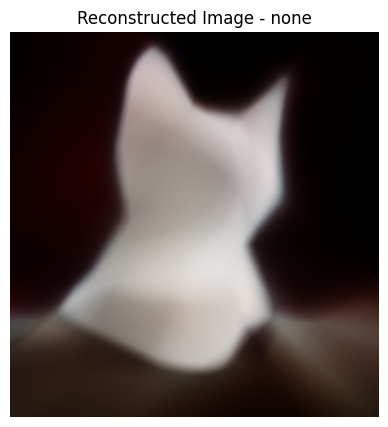

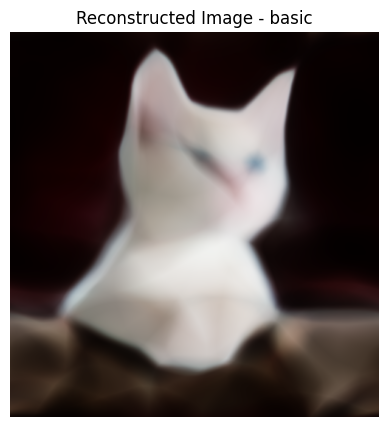

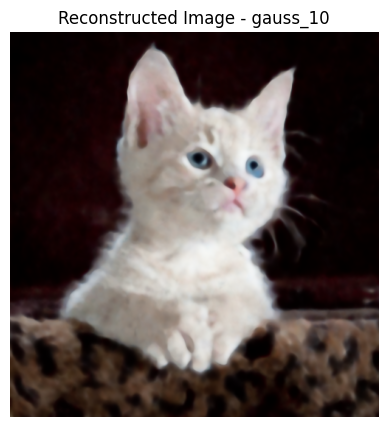

In [9]:
for mapping in selected_mappings:
    plot_results(models[mapping], B_dict[mapping], mapping)

# 5. Putting it all Together

In [ ]:
ray_bundles = []
for pose in poses:
    rays_o, rays_d = get_rays(H, W, focal, torch.tensor(pose))
    origins = rays_o.reshape(-1, 3)
    directions = rays_d.reshape(-1, 3)

    num_rays = origins.shape[0]
    nears = torch.full((num_rays, 1), 2.0, device=origins.device)  
    fars  = torch.full((num_rays, 1), 6.0, device=origins.device)  

    ray_bundles.append(RayBundle(origins, directions, nears, fars))

print(f"Created {len(ray_bundles)} ray bundles, each with {len(ray_bundles[0])} rays.")

def positional_encoding(x, num_freqs=10):
    out = [x]
    for i in range(num_freqs):
        for fn in [torch.sin, torch.cos]:
            out.append(fn(2.0**i * x))
    return torch.cat(out, dim=-1)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = nerf_mlp(input_dim=63, dir_dim=27).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Training settings
num_epochs = 30
num_samples = 64
perturb = True
num_freqs_pos = 10
num_freqs_dir = 4
chunk = 32768  # number of points per MLP forward pass
batch_size = 2  # number of images per mini-batch

def compute_psnr(mse):
    return -10.0 * torch.log10(mse)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(0, len(ray_bundles), batch_size):
        batch_ray_bundles = ray_bundles[i:i+batch_size]
        all_origins = []
        all_directions = []
        all_targets = []

        for img_idx, ray_bundle in enumerate(batch_ray_bundles):
            all_origins.append(ray_bundle.origins)
            all_directions.append(ray_bundle.directions)
            all_targets.append(torch.tensor(images[i + img_idx], dtype=torch.float32).reshape(-1, 3))

        all_origins = torch.cat(all_origins, dim=0).to(device)
        all_directions = torch.cat(all_directions, dim=0).to(device)
        all_targets = torch.cat(all_targets, dim=0).to(device)

        nears = torch.full((all_origins.shape[0], 1), 2.0, device=device)
        fars  = torch.full((all_origins.shape[0], 1), 6.0, device=device)
        ray_bundle = RayBundle(all_origins, all_directions, nears, fars)
        ray_samples = ray_bundle.stratified_sample(num_samples=num_samples, perturb=perturb)
        coords = ray_samples.compute_sample_coordinates()

        coords_enc = positional_encoding(coords, num_freqs=num_freqs_pos).float()
        dirs_enc = positional_encoding(all_directions[:, None, :].expand_as(coords), num_freqs=num_freqs_dir).float()

        # Flatten for MLP
        coords_enc_flat = coords_enc.reshape(-1, coords_enc.shape[-1])
        dirs_enc_flat = dirs_enc.reshape(-1, dirs_enc.shape[-1])
        rgb_chunks = []
        sigma_chunks = []
        for j in range(0, coords_enc_flat.shape[0], chunk):
            coords_chunk = coords_enc_flat[j:j+chunk]
            dirs_chunk = dirs_enc_flat[j:j+chunk]
            sigma_chunk, rgb_chunk = model(coords_chunk, dirs_chunk)
            rgb_chunks.append(rgb_chunk)
            sigma_chunks.append(sigma_chunk)

        sigma = torch.cat(sigma_chunks, dim=0).view(coords.shape[0], coords.shape[1], 1)
        rgb = torch.cat(rgb_chunks, dim=0).view(coords.shape[0], coords.shape[1], 3)

        deltas = ray_samples.compute_deltas()
        rgb_map, weights, opacity = volume_render(sigma, rgb, deltas)

        # Loss & optimization
        loss = F.mse_loss(rgb_map, all_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_size  # accumulate weighted by batch size

    # Average loss over the dataset
    epoch_loss /= len(ray_bundles)
    epoch_psnr = compute_psnr(torch.tensor(epoch_loss))
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.6f} | PSNR: {epoch_psnr:.2f} dB")

# ✅ Save the model weights after training
save_path = "nerf_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Epoch 1 | Loss: 0.053099 | PSNR: 12.75 dB
Epoch 2 | Loss: 0.032919 | PSNR: 14.83 dB
Epoch 3 | Loss: 0.025018 | PSNR: 16.02 dB
Epoch 4 | Loss: 0.018219 | PSNR: 17.39 dB
Epoch 5 | Loss: 0.014011 | PSNR: 18.54 dB
Epoch 6 | Loss: 0.011613 | PSNR: 19.35 dB
Epoch 7 | Loss: 0.010020 | PSNR: 19.99 dB
Epoch 8 | Loss: 0.009211 | PSNR: 20.36 dB
Epoch 9 | Loss: 0.008326 | PSNR: 20.80 dB
Epoch 10 | Loss: 0.007798 | PSNR: 21.08 dB
Epoch 11 | Loss: 0.007354 | PSNR: 21.34 dB
Epoch 12 | Loss: 0.007032 | PSNR: 21.53 dB
Epoch 13 | Loss: 0.006850 | PSNR: 21.64 dB
Epoch 14 | Loss: 0.006534 | PSNR: 21.85 dB
Epoch 15 | Loss: 0.006326 | PSNR: 21.99 dB
Epoch 16 | Loss: 0.006137 | PSNR: 22.12 dB
Epoch 17 | Loss: 0.005961 | PSNR: 22.25 dB
Epoch 18 | Loss: 0.005752 | PSNR: 22.40 dB
Epoch 19 | Loss: 0.005568 | PSNR: 22.54 dB
Epoch 20 | Loss: 0.005384 | PSNR: 22.69 dB
Epoch 21 | Loss: 0.005248 | PSNR: 22.80 dB
Epoch 22 | Loss: 0.005101 | PSNR: 22.92 dB
Epoch 23 | Loss: 0.004951 | PSNR: 23.05 dB
Epoch 24 | Loss: 0.0

In [ ]:
#| hide

device = "cuda" if torch.cuda.is_available() else "cpu"
model = nerf_mlp(input_dim=63, dir_dim=27).to(device)
model.load_state_dict(torch.load(r"C:\Users\soufiene\OneDrive\Desktop\3D\nerf_model.pth", map_location=device))
model.eval()

#  Camera Pose Helpers 
def trans_t(t):
    return torch.tensor([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,1,t],
        [0,0,0,1],
    ], dtype=torch.float32, device=device)

def rot_phi(phi):
    phi = phi * np.pi / 180.0
    return torch.tensor([
        [1, 0,           0,          0],
        [0, np.cos(phi), -np.sin(phi), 0],
        [0, np.sin(phi),  np.cos(phi), 0],
        [0, 0,           0,          1],
    ], dtype=torch.float32, device=device)

def rot_theta(theta):
    theta = theta * np.pi / 180.0
    return torch.tensor([
        [ np.cos(theta), 0, -np.sin(theta), 0],
        [ 0,             1,  0,             0],
        [ np.sin(theta), 0,  np.cos(theta), 0],
        [ 0,             0,  0,             1],
    ], dtype=torch.float32, device=device)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi) @ c2w
    c2w = rot_theta(theta) @ c2w
    align = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=torch.float32, device=device)
    return align @ c2w


def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(
        torch.arange(W, dtype=torch.float32, device=device),
        torch.arange(H, dtype=torch.float32, device=device),
        indexing='xy'
    )
    dirs = torch.stack([
        (i - W*0.5)/focal,
        -(j - H*0.5)/focal,
        -torch.ones_like(i)
    ], dim=-1)
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], dim=-1)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    return rays_o, rays_d
@torch.no_grad()
def render_rays(model, rays_o, rays_d, N_samples=64, near=2.0, far=6.0):
    H, W = rays_o.shape[:2]
    N_rays = H*W

    rays_o_flat = rays_o.reshape(-1,3)
    rays_d_flat = rays_d.reshape(-1,3)

    z_vals = torch.linspace(near, far, N_samples, device=device)  # [N_samples]
    pts = rays_o_flat[:, None, :] + rays_d_flat[:, None, :] * z_vals[None, :, None]  # [N_rays, N_samples, 3]

    pts_enc = positional_encoding(pts, num_freqs=num_freqs_pos)
    dirs_enc = positional_encoding(rays_d_flat[:, None, :].expand_as(pts), num_freqs=num_freqs_dir)

    pts_enc_flat = pts_enc.reshape(-1, pts_enc.shape[-1])
    dirs_enc_flat = dirs_enc.reshape(-1, dirs_enc.shape[-1])


    chunk = 32768
    rgb_chunks, sigma_chunks = [], []
    for i in range(0, pts_enc_flat.shape[0], chunk):
        sigma_chunk, rgb_chunk = model(pts_enc_flat[i:i+chunk], dirs_enc_flat[i:i+chunk])
        rgb_chunks.append(rgb_chunk)
        sigma_chunks.append(sigma_chunk)

    rgb = torch.cat(rgb_chunks, dim=0).view(N_rays, N_samples, 3)
    sigma = torch.cat(sigma_chunks, dim=0).view(N_rays, N_samples, 1)


    deltas = z_vals[1:] - z_vals[:-1]
    deltas = torch.cat([deltas, deltas[-1:]], dim=0)[None, :, None]

    alpha = 1 - torch.exp(-sigma * deltas)
    trans = torch.cumprod(torch.cat([torch.ones((alpha.shape[0],1,1), device=device), 1-alpha + 1e-10], dim=1), dim=1)[:, :-1, :]
    weights = alpha * trans

    rgb_map = (weights * rgb).sum(dim=1).view(H, W, 3)
    depth_map = (weights * z_vals[None, :, None]).sum(dim=1).view(H, W)

    return rgb_map, depth_map

H, W = 128, 128        
focal = 120.0            
num_samples = 64         
num_freqs_pos = 10       
num_freqs_dir = 4

frames = []
for th in np.linspace(0, 360, 60, endpoint=False):
    c2w = pose_spherical(th, -30, 4.0)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, _ = render_rays(model, rays_o, rays_d, N_samples=num_samples)
    img = np.clip(rgb.cpu().numpy(), 0, 1)
    frames.append(go.Frame(data=[go.Image(z=(img*255).astype(np.uint8))], name=str(th)))

fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        width=500,
        height=500,
        title="360° NeRF Viewer",
        updatemenus=[dict(type="buttons",
                          showactive=False,
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None, {"frame": {"duration": 50, "redraw": True},
                                                     "fromcurrent": True}])])]
    )
)
fig.write_html("nerf_360.html")

<iframe src="nerf_360.html" width="700" height="500" style="border:none;"></iframe>
